Calculate the Bayes Factor for $u-r$ to determine whether the void and wall samples are drawn from the same or different parent distributions.

In [1]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import pickle

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import matplotlib
import matplotlib.pyplot as plt

from functions import Model_1_plot, Model_2_plot, uniform, jeffreys, Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler
#from functions_gauss import Model_1_fit, Model_2_fit, Model_1_sampler, Model_2_sampler

np.set_printoptions(threshold=sys.maxsize)

In [2]:
matplotlib.rc('font', size=14)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '/home/codebind/Bootes/NSA_Full.fits'

hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]
del data

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]
del catalog_SDSS

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]
del catalog_north

In [5]:
ur_NSA = np.array(catalog_main['u_r'])
del catalog_main

## Kirshner Data

In [6]:
KNSA = Table.read('/home/codebind/Bootes/My Code/KNSA.txt', format = "ascii.commented_header")

# Fit the color distributions with skewnormal distributions

Both one- and two-parent models

This is a bimodal distribution

In [20]:
#ur_bins = np.linspace(0, 4, 170)
ur_bins = np.linspace(0, 5, 100)
k_bins = np.linspace(0, 5, 30)

### 1-parent model

In [50]:
ur_fit_bounds1 = [[0.001, 10],    # s ........ Gaussian 1 to 2 scale factor
                  [8000, 30000], # a ........ Gaussian a amplitude
                  [1, 1.8],     # mu_a ..... Gaussian a location
                  [.01, 5],    # sigma_a .. Gaussian a scale
                  [-5, 10],      # skew_a ... Gaussian a skew
                  [1000, 50000], # b ........ Gaussian b amplitude
                  [1.8, 2.6],   # mu_b ..... Gaussian b location
                  [.01, 5],    # sigma_b .. Gaussian b scale
                  [-5, 5],      # skew_b ... Gaussian b skew
                  [1000, 10000],  # c
                  [2.6, 3],     # mu_c
                  [.1, 6],    # sigma_c
                  [-20, 10]]    #skew_c
                  

ur_bestfit1 = Model_1_fit(ur_fit_bounds1, 
                             ur_NSA, 
                             KNSA['U-R'], 
                             ur_bins,
                             k_bins,
                             3)

ur_bestfit1

running minimizer...this might take a few minutes...


      fun: 743.3471111510306
 hess_inv: <13x13 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.65678499e+00, -1.04469807e-02, -7.17545849e-01, -3.37524851e-01,
        7.56699596e-02, -3.38343129e-01,  7.41979425e+00,  2.99223759e-02,
        2.38287612e-02, -6.35402456e-02,  2.82824284e+02,  4.80315521e-01,
        2.66368261e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 8652
      nit: 454
     njev: 618
   status: 0
  success: True
        x: array([ 1.50452941e-03,  1.79369511e+04,  1.40729116e+00,  8.10988583e-01,
        2.37438764e+00,  1.00003752e+03,  1.80000000e+00,  1.70503553e+00,
       -3.82728967e-01,  7.01873979e+03,  2.60000000e+00,  2.37521359e-01,
        3.92765490e-01])

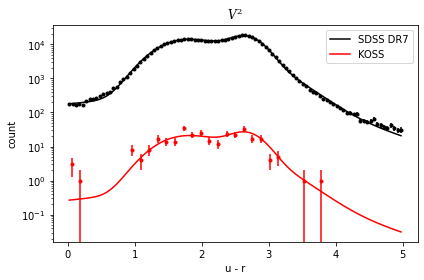

In [51]:
Model_1_plot(ur_bestfit1.x, 
             ur_NSA, 
             KNSA['U-R'], 
             ur_bins,
             k_bins,
             3, 
             xlabel_text='u - r', 
             title_text='$V^2$')

### Nested sampling of Likelihood and Priors

#### V$^2$

In [52]:
def prior_xform1_bi_V2(u):
    '''
    Priors for the 9 parameters of bimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(5e-4, 5e-3, u[0])
    
    a = jeffreys(8000, 20000, u[1])
    mu_a = uniform(0, 1.5, u[2])
    sigma_a = uniform(0.1, 3, u[3])
    skew_a = uniform(0, 10, u[4])
    
    b = jeffreys(1e3, 10e3, u[5])
    mu_b = uniform(1.5, 2.2, u[6])
    sigma_b = uniform(0.01, 5, u[7])
    skew_b = uniform(-10, 1, u[8])
    
    c = jeffreys(1e3, 10e3, u[9])
    mu_c = uniform(2.2, 3, u[10])
    sigma_c = uniform(.01, 5, u[11])
    skew_c = uniform(-10, 10, u[12])

    return s, a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b, c, mu_c, sigma_c, skew_c

In [53]:
Model_1_sampler(prior_xform1_bi_V2, 
                ur_NSA, 
                KNSA['U-R'], 
                ur_bins, 
                k_bins,
                3, 
                '_ur_V2')

running the nested sampler... this might take from minutes to hours...


73654it [33:22, 36.78it/s, batch: 1 | bound: 24 | nc: 33 | ncall: 2312915 | eff(%):  3.184 | loglstar: -651.610 < -644.200 < -648.201 | logz: -707.589 +/-  0.246 | stop:  0.680]             


sampler output saved as pickle file 'dynesty_output/sampler_results_model1_ur_V2'


In [8]:
temp_infile = open('dynesty_output/sampler_results_model1_ur_V2.pickle', 'rb')
dres1_V2_ur = pickle.load(temp_infile)
temp_infile.close()

In [9]:
labels1_bi = ['s', 'a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 
                   'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$', 'c', r'$\mu_c$', r'$\sigma_c$', 'skew$_c$']
labels2_bi = ['$a_1$', r'$\mu_{1a}$', r'$\sigma_{1a}$', 'skew$_{1a}$', 
              '$b_1$', r'$\mu_{1b}$', r'$\sigma_{1b}$', 'skew$_{1b}$',
              '$c_1$', r'$\mu_{1c}$', r'$\sigma_{1c}$', 'skew$_{1c}$',
              '$a_2$', r'$\mu_{2a}$', r'$\sigma_{2a}$', 'skew$_{2a}$', 
              '$b_2$', r'$\mu_{2b}$', r'$\sigma_{2b}$', 'skew$_{2b}$',
             '$c_2$', r'$\mu_{2c}$', r'$\sigma_{2c}$', 'skew_{2c}']

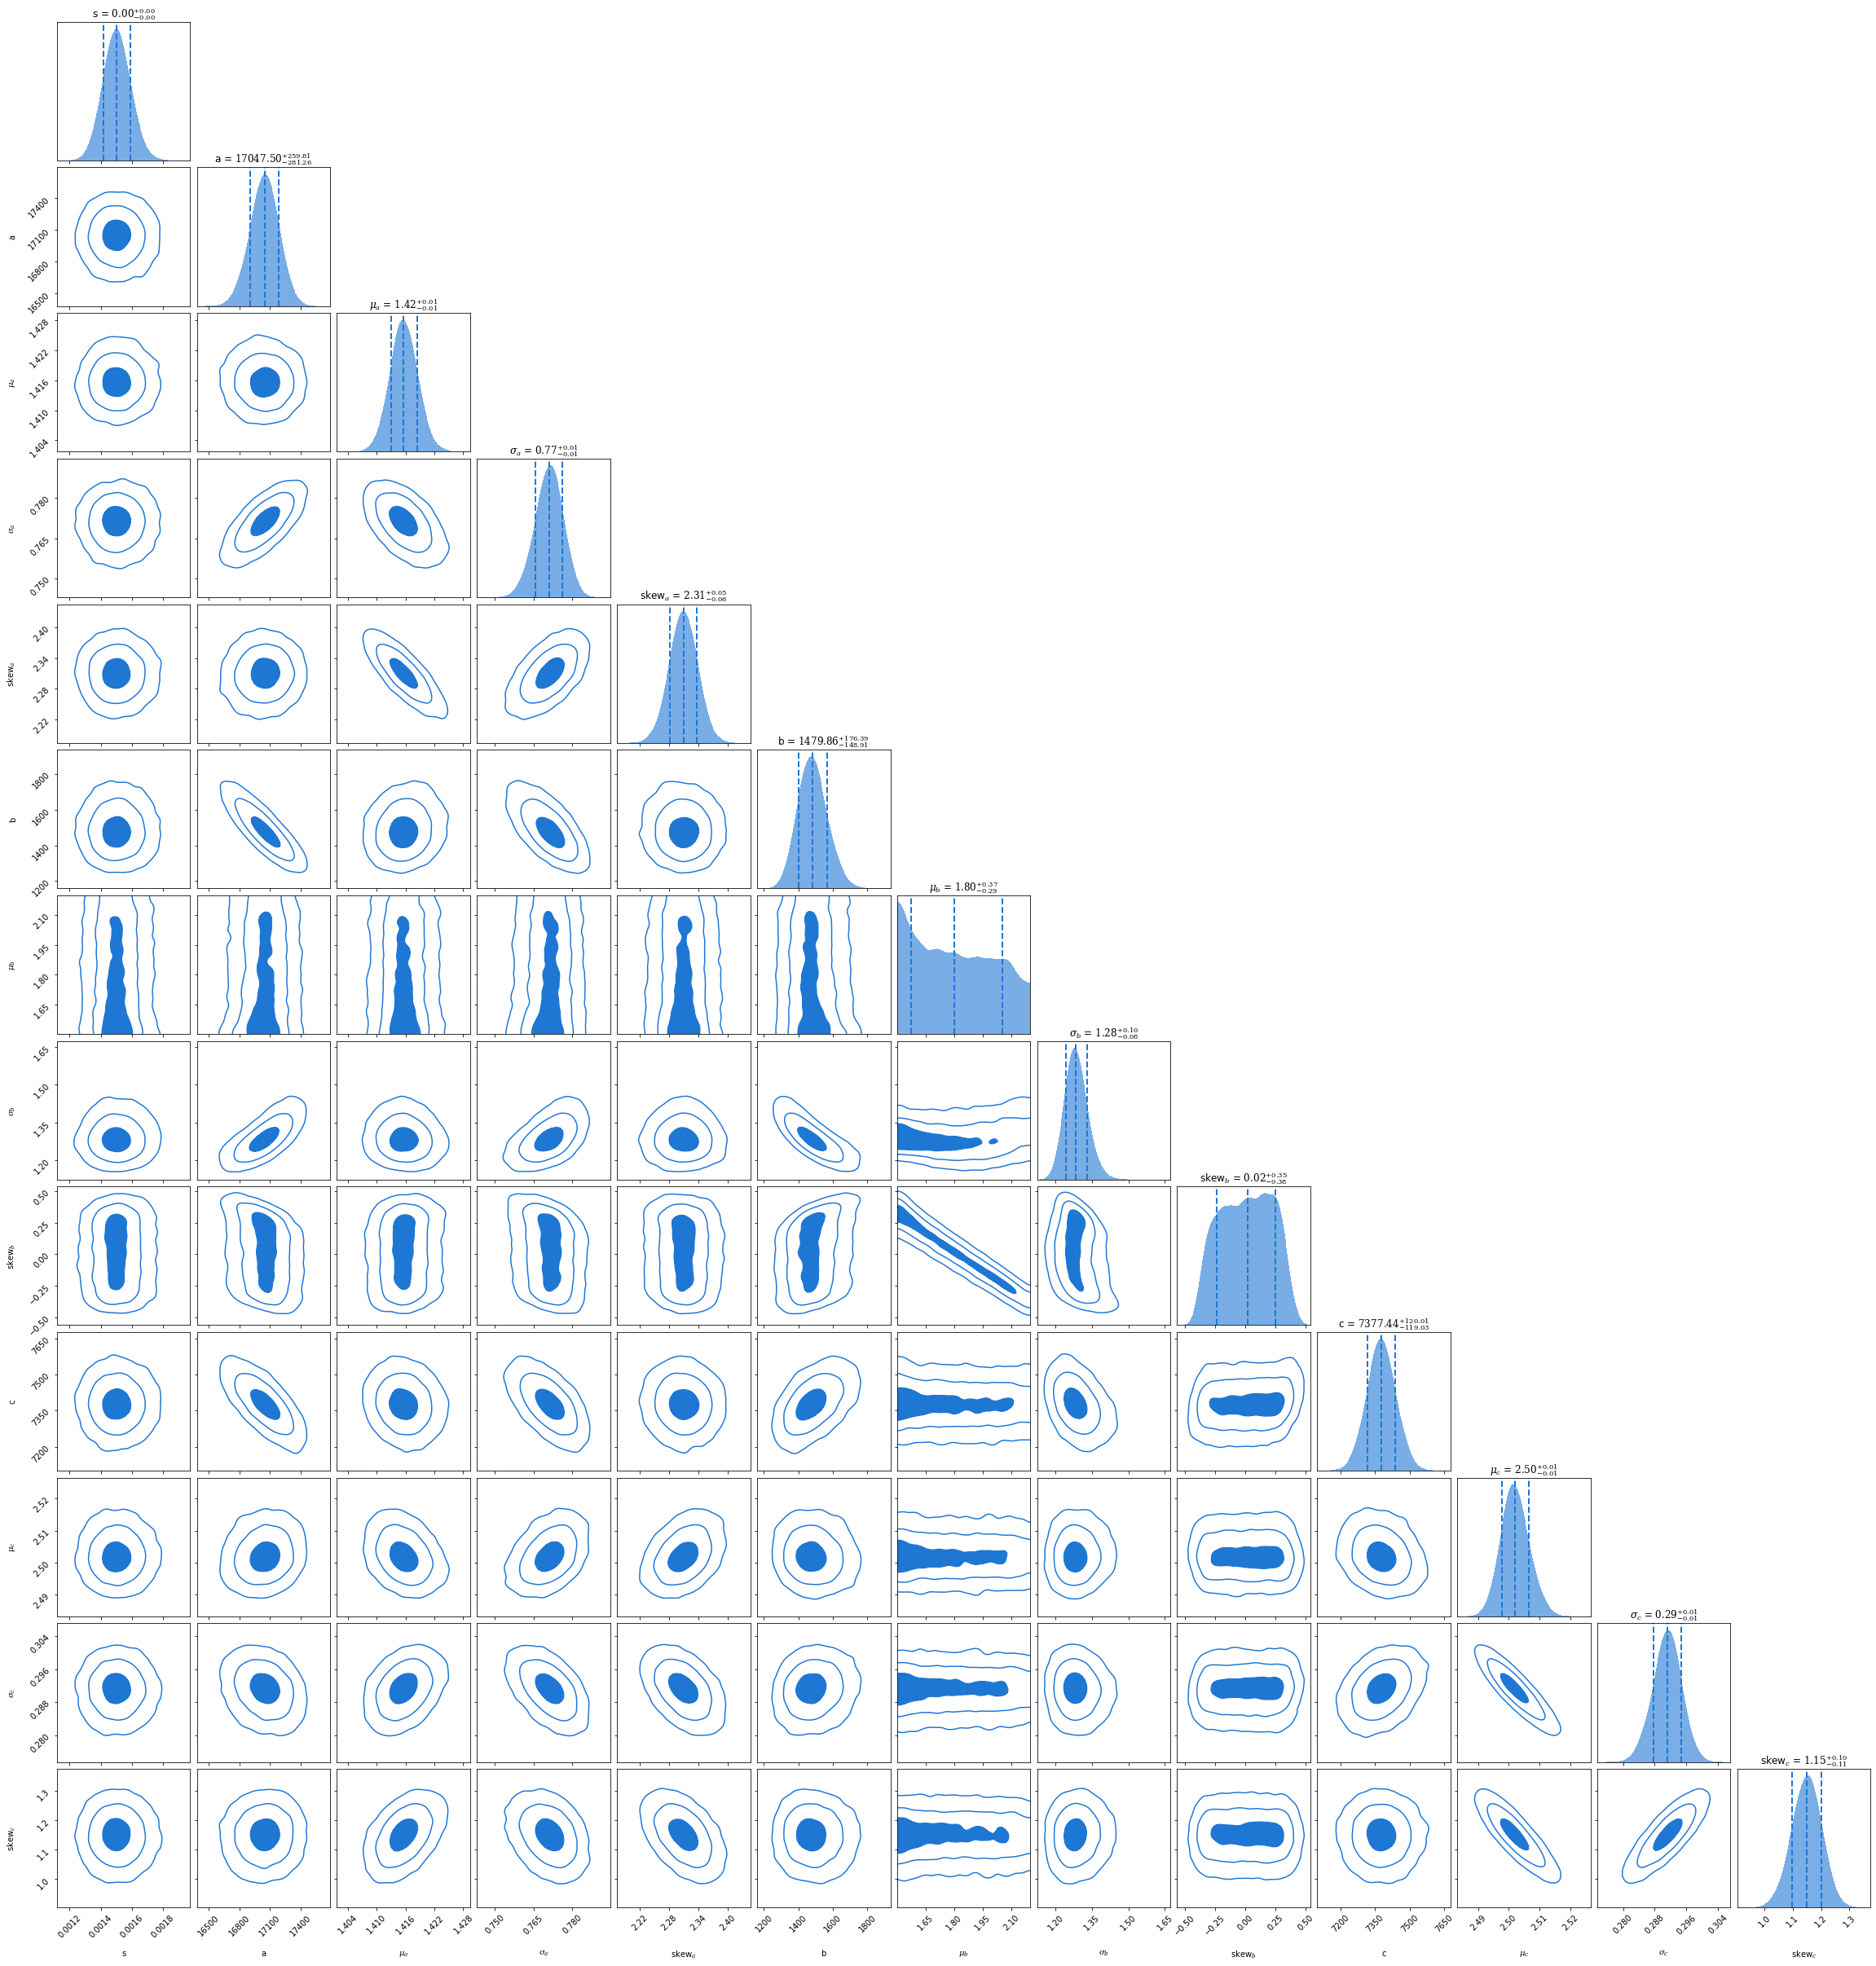

In [10]:
n_params = len(labels1_bi)

fig, axes = dyplot.cornerplot(dres1_V2_ur, smooth=0.03, 
                              labels=labels1_bi, 
#                               truths=ur_bestfit1.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

In [57]:
# n_params = len(labels1_bi)

# fig, axes = dyplot.traceplot(dres1_V2_ur, 
#                              labels=labels1_bi, 
# #                              truths=ur_bestfit1.x,
#                              fig=plt.subplots(n_params, 3, figsize=(n_params, 2.6*n_params)), 
#                              thin=10)

# fig.tight_layout();

In [11]:
lnzM1_V2_ur = dres1_V2_ur.logz[-1]
lnzM1_V2_ur

-707.5784193499203

In [12]:
ur_bestfit1_dynesty,_ = dyfunc.mean_and_cov(dres1_V2_ur.samples, 
                                               np.exp(dres1_V2_ur.logwt - lnzM1_V2_ur))

ur_bestfit1_dynesty

array([1.50464763e-03, 1.70446506e+04, 1.41567662e+00, 7.71025254e-01,
       2.30912695e+00, 1.48316100e+03, 1.81220349e+00, 1.28607322e+00,
       9.87708558e-03, 7.37784229e+03, 2.50215417e+00, 2.91143860e-01,
       1.14929322e+00])

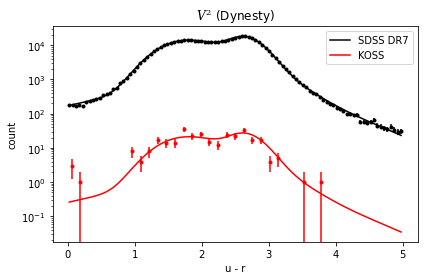

In [14]:
# Model_1_plot(ur_bestfit1.x, 
#              ur_NSA, 
#              KNSA['U-R'], 
#              ur_bins, 
#              k_bins,
#              3, 
#              xlabel_text='u - r', 
#              title_text='$V^2$ (minimize)')

Model_1_plot(ur_bestfit1_dynesty, 
             ur_NSA, 
             KNSA['U-R'], 
             ur_bins, 
             k_bins,
             3, 
             xlabel_text='u - r', 
             title_text='$V^2$ (Dynesty)')

## 2-parent model

In [27]:
# 1 = wall, 2 = void

ur_fit_bounds2 = [[8000, 50000],  # a1 ........ Gaussian A1 amplitude
                  [0, 1.6],     # mu_a1 ..... Gaussian A1 location
                  [0.01, 3],    # sigma_a1 .. Gaussian A1 scale
                  [-5, 5],     # skew_a1 ... Gaussian A1 skew
                  
                  [5000, 10000], # b1 ........ Gaussian B1 amplitude
                  [1.6, 2.6],   # mu_b1 ..... Gaussian B1 location
                  [0.01, 3],     # sigma_b1 .. Gaussian B1 scale
                  [-5, 5],    # skew_b1 ... Gaussian B1 skew
                  
                  [100, 2000], #c1
                  [2.6, 3.5],     #mu_c1
                  [.01, 10],      #sigma_c1
                  [-5, 5],      #skew_c1
                  
                  
                  
                  [.1, 500], # a2 ........ Gaussian A2 amplitude
                  [.5, 2.1],     # mu_a2 ..... Gaussian A2 location
                  [0.01, 3],     # sigma_a2 .. Gaussian A2 scale
                  [-2.5, 10],       # skew_a2 ... Gaussian A2 skew
                  
                  [.1, 500], # b2 ........ Gaussian B2 amplitude
                  [2.1, 3],   # mu_b2 ..... Gaussian B2 location
                  [0.01, 3],     # sigma_b2 .. Gaussian B2 scale
                  [-10, 2.5]]      # skew_b2 ... Gaussian B2 skew

ur_bestfit2 = Model_2_fit(ur_fit_bounds2, 
                             ur_NSA, 
                             KNSA['U-R'], 
                             ur_bins, 
                          k_bins,
                             [3,2])

ur_bestfit2

running minimizer...this might take a few minutes...


      fun: 859.0032330091319
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.34821753e-02, -1.55604085e+01,  3.64766036e+01,  2.21839402e+00,
        7.72781011e-02,  4.22562382e+01,  3.12015118e+01, -3.57133560e+00,
       -7.14870396e-02, -3.56467356e+00,  3.60321339e+00,  2.09995507e+00,
       -4.86676300e+00, -2.93766790e-02,  3.98108571e-01,  1.93267608e-03,
       -6.71195666e-01, -4.51268536e+00, -6.89657331e+00, -7.74525624e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 9408
      nit: 369
     njev: 448
   status: 0
  success: True
        x: array([ 1.39477741e+04,  1.52930458e+00,  5.04926982e-01,  1.07203119e+00,
        9.99998520e+03,  2.45443954e+00,  3.40317292e-01,  1.27526042e+00,
        1.99999821e+03,  3.41422197e+00,  1.85548987e+00, -2.34598085e+00,
        3.41905244e-01,  1.70357093e+00,  2.98756561e+00,  9.99998117e+00,
        4.64310453e+01,  2.92115100e+00,  1.06134608e+00, -9.99197673e+00])

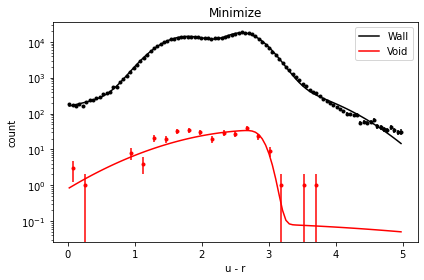

In [28]:
Model_2_plot(ur_bestfit2.x, 
             ur_NSA, 
             KNSA['U-R'], 
             ur_bins,
             k_bins,
             [3,2], 
             xlabel_text='u - r', 
             title_text='Minimize')

In [36]:
def prior_xform2_bi_V2(u):
    '''
    Priors for the 16 parameters of bimodal M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(5e3, 15e3, u[0])
    mu_a1 = uniform(1, 1.6, u[1])
    sigma_a1 = uniform(0.01, 2, u[2])
    skew_a1 = uniform(-5, 5, u[3])

    b1 = jeffreys(1e4, 2e4, u[4])
    mu_b1 = uniform(1.6, 2.6, u[5])
    sigma_b1 = uniform(0.01, 2, u[6])
    skew_b1 = uniform(-5, 5, u[7])
    
    c1 = jeffreys(1e4, 2e4, u[8])
    mu_c1 = uniform(2.6, 3.5, u[9])
    sigma_c1 = uniform(0.01, 2, u[10])
    skew_c1 = uniform(-5, 5, u[11])
    
    a2 = jeffreys(.001, 100, u[12])
    mu_a2 = uniform(1, 2.1, u[13])
    sigma_a2 = uniform(.01, 20, u[14])
    skew_a2 = uniform(-5, 5, u[15])

    b2 = jeffreys(1, 100, u[16])
    mu_b2 = uniform(2.1, 3, u[17])
    sigma_b2 = uniform(0.01, 2, u[18])
    skew_b2 = uniform(-5, 5, u[19])

    return a1, mu_a1, sigma_a1, skew_a1, b1, mu_b1, sigma_b1, skew_b1, c1, mu_c1, sigma_c1, skew_c1, \
           a2, mu_a2, sigma_a2, skew_a2, b2, mu_b2, sigma_b2, skew_b2

In [37]:
Model_2_sampler(prior_xform2_bi_V2, 
                ur_NSA, 
                KNSA['U-R'], 
                ur_bins, 
                k_bins,
                [3,2], 
                '_ur')

running the nested sampler... this might take from minutes to hours...


71902it [22:13, 53.94it/s, batch: 0 | bound: 453 | nc: 1 | ncall: 2458061 | eff(%):  2.925 | loglstar:   -inf < -3235.065 <    inf | logz: -3301.328 +/-  0.240 | dlogz:  0.000 >  0.010]   


sampler output saved as pickle file 'dynesty_output/sampler_results_model2_ur_V2'


In [38]:
temp_infile = open('dynesty_output/sampler_results_model2_ur.pickle', 'rb')
dres2_V2_ur = pickle.load(temp_infile)
temp_infile.close()

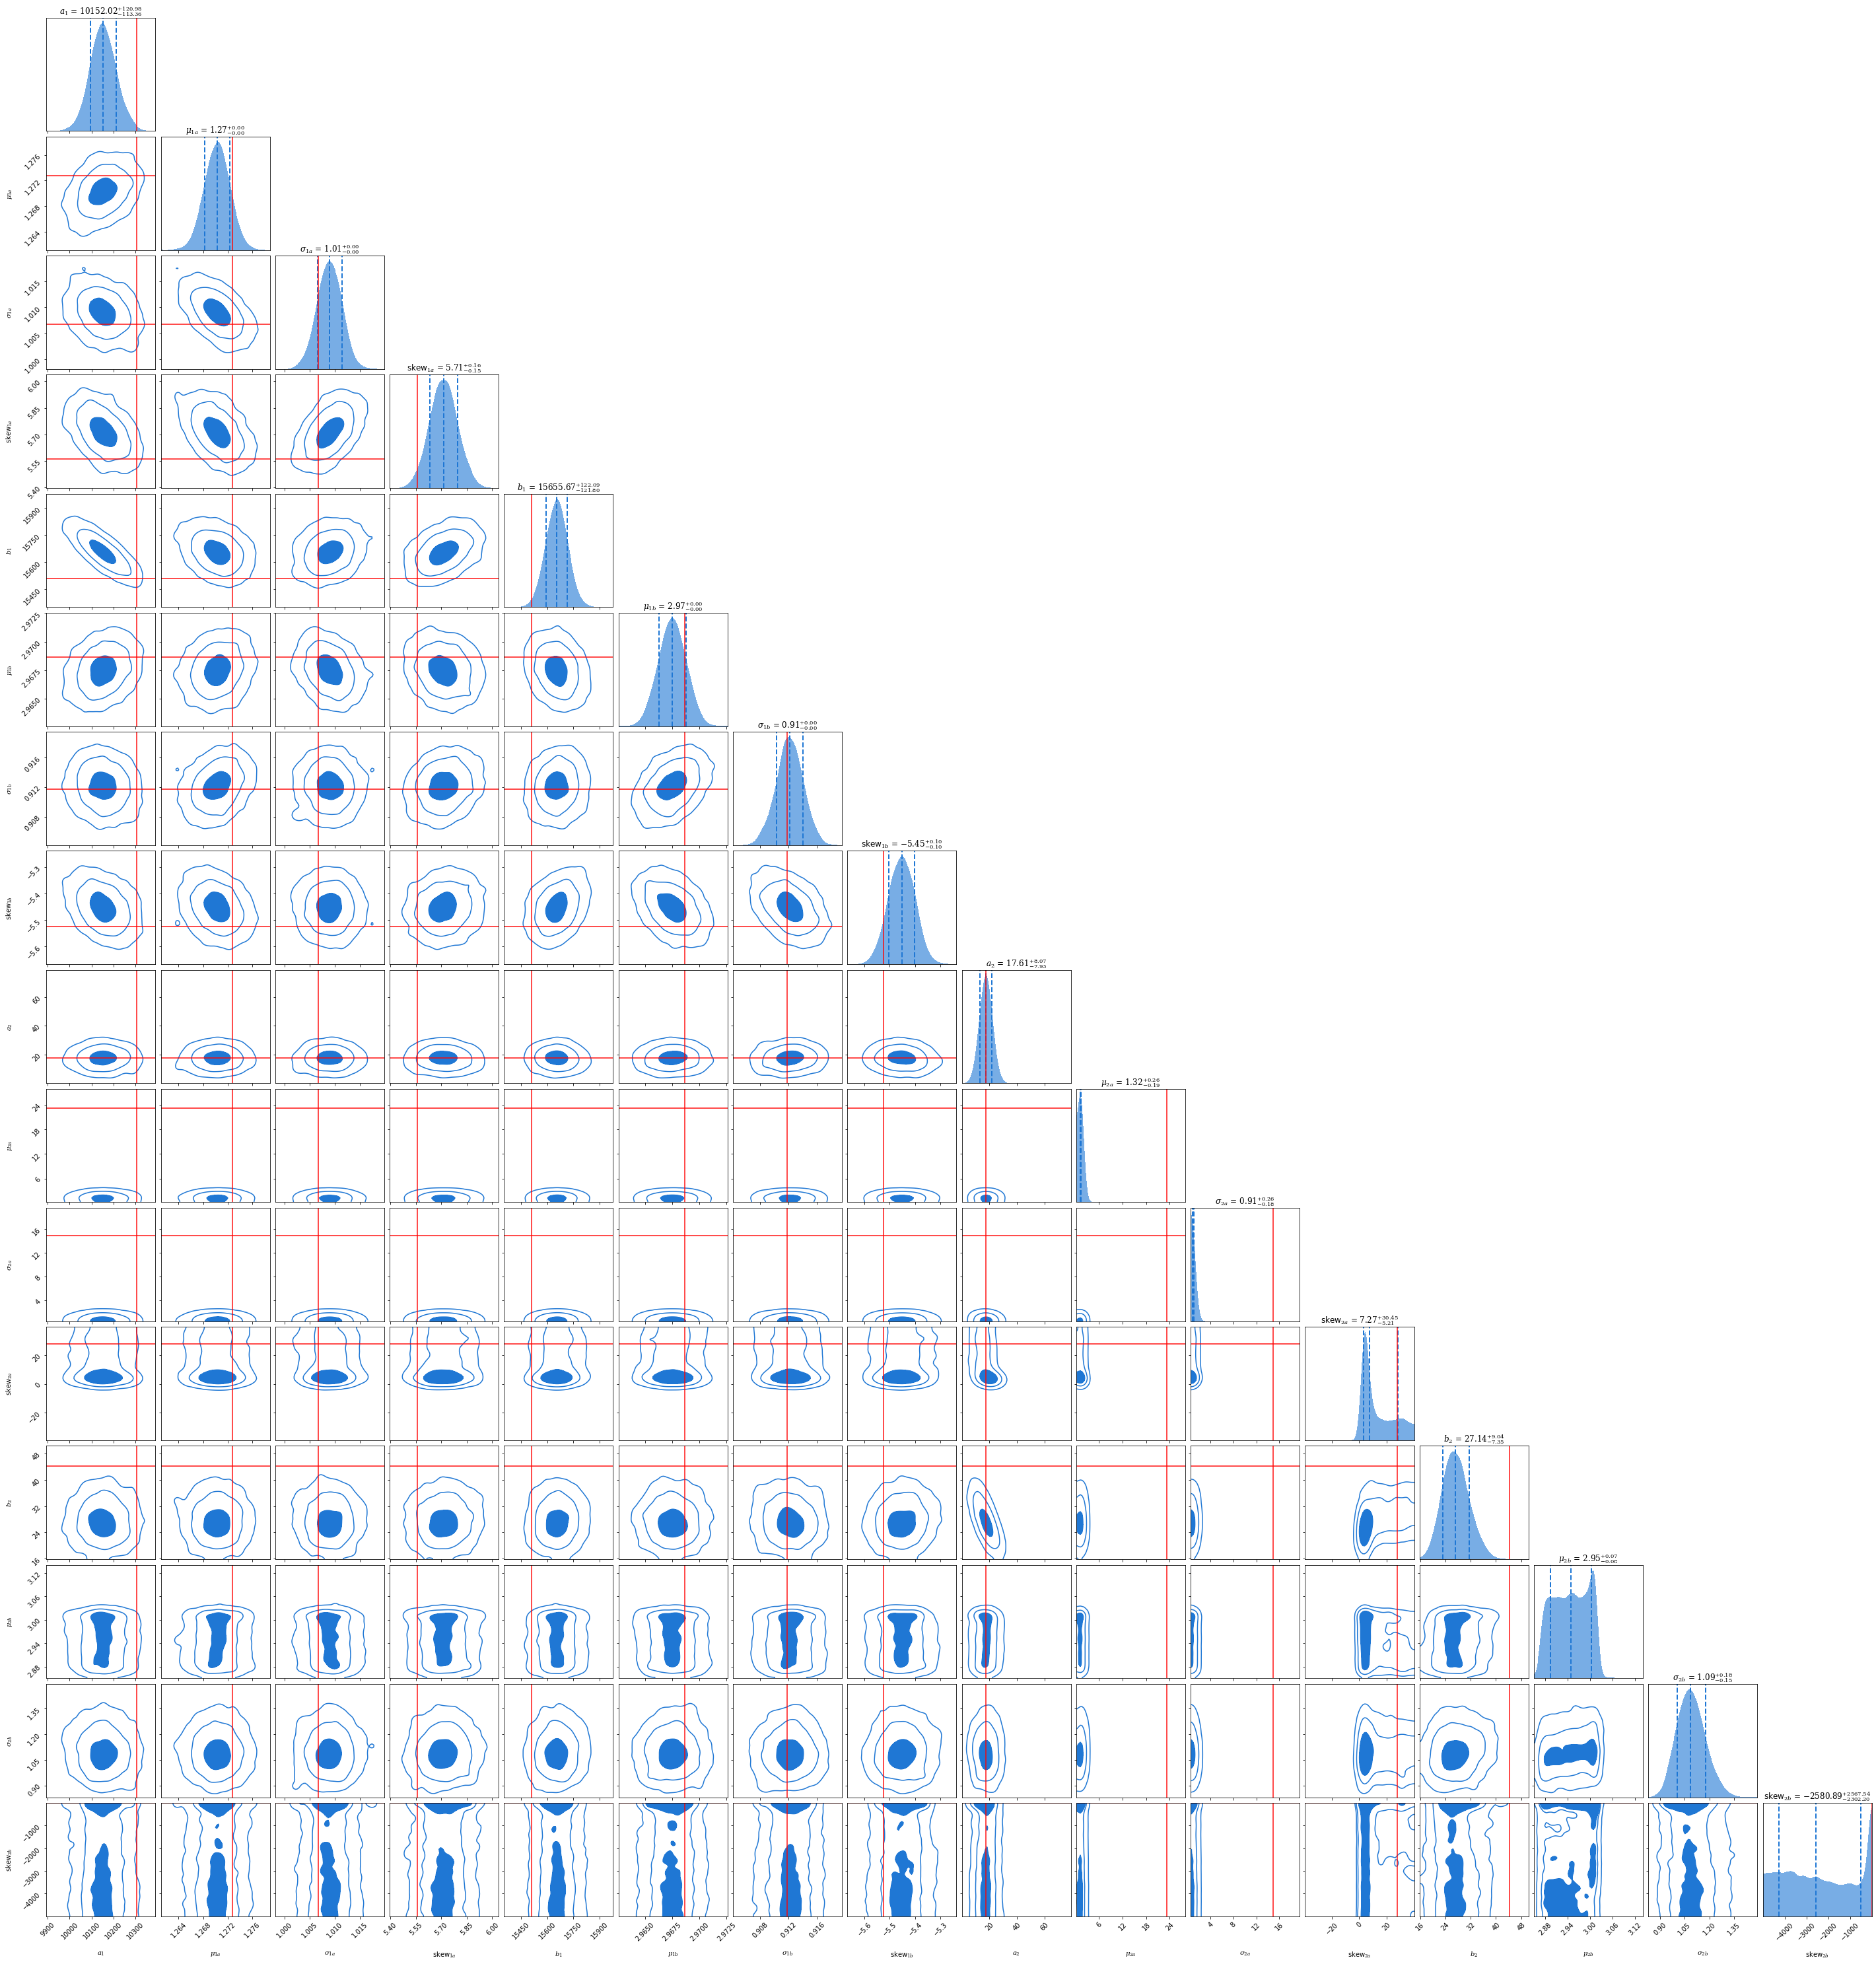

In [39]:
n_params = len(labels2_bi)

fig, axes = dyplot.cornerplot(dres2_V2_ur, smooth=0.03, 
                              labels=labels2_bi, 
                              truths=ur_bestfit2.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

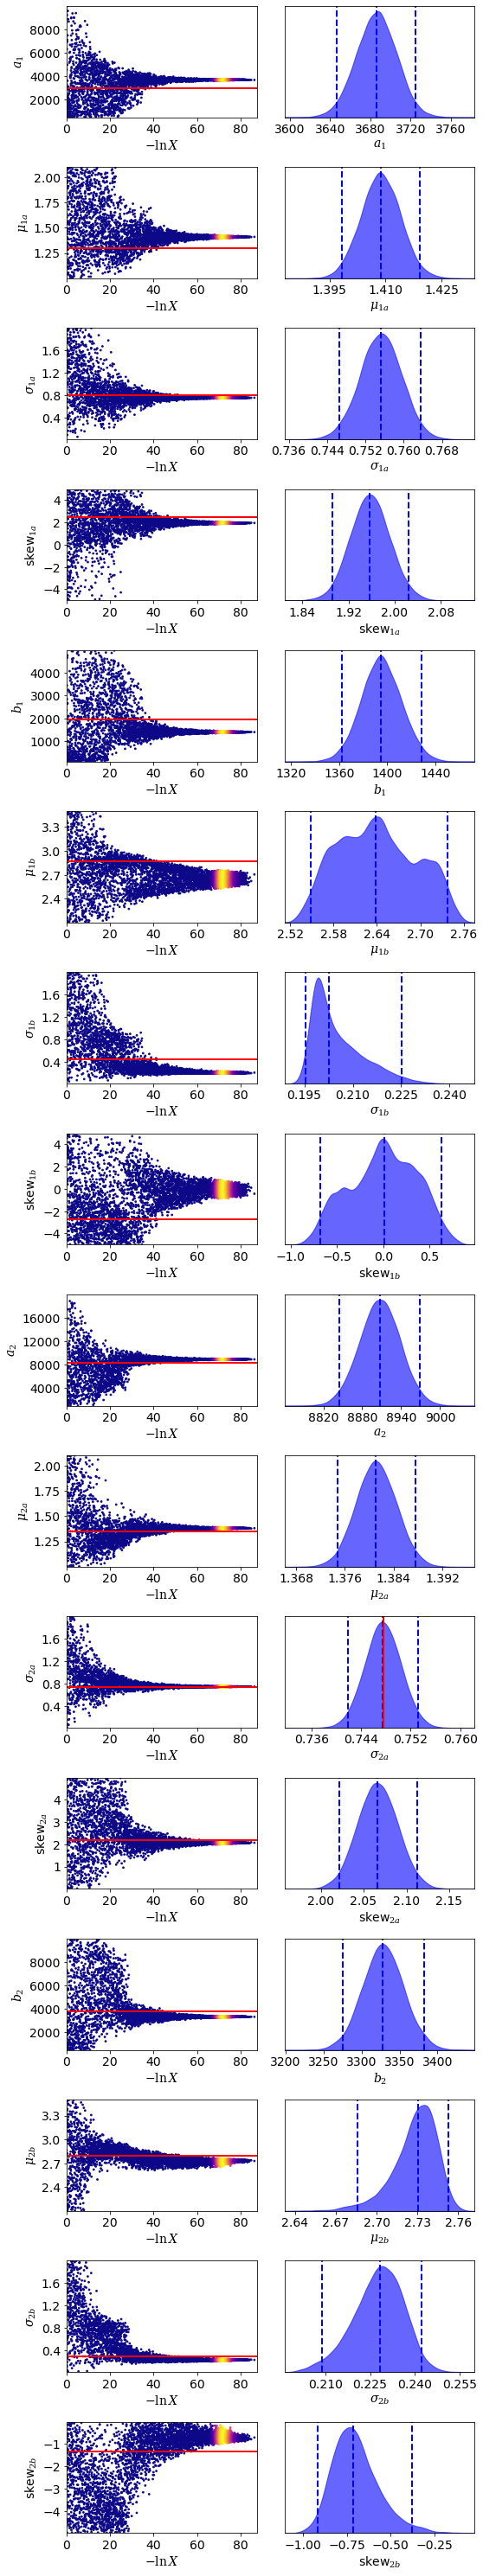

In [46]:
# n_params = len(labels2_bi)

# fig, axes = dyplot.traceplot(dres2_V2_ur, 
#                              labels=labels2_bi, 
#                              truths=V2_ur_bestfit2.x,
#                              fig=plt.subplots(n_params, 2, figsize=(0.5*n_params, 2.6*n_params)), 
#                              thin=10)

# fig.tight_layout();

In [47]:
lnzM2_V2_ur = dres2_V2_ur.logz[-1]
lnzM2_V2_ur

-1236.864949723582

In [48]:
V2_ur_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_V2_ur.samples, 
                                               np.exp(dres2_V2_ur.logwt - lnzM2_V2_ur))

V2_ur_bestfit2_dynesty

array([ 3.68597803e+03,  1.40871329e+00,  7.55199369e-01,  1.95738665e+00,
        1.39506856e+03,  2.64010666e+00,  2.05260318e-01, -5.40654204e-03,
        8.90703670e+03,  1.38112831e+00,  7.47501489e-01,  2.06634328e+00,
        3.32860162e+03,  2.72777985e+00,  2.27578066e-01, -6.98066746e-01])

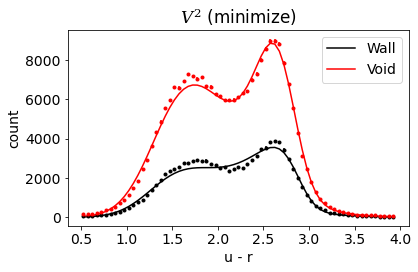

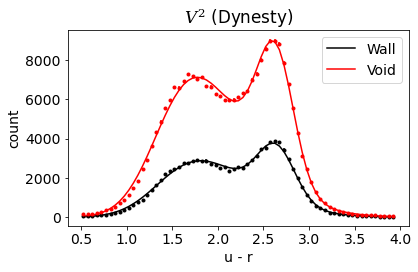

In [49]:
Model_2_plot(V2_ur_bestfit2.x, 
             ur_NSA, 
             KNSA['U-R'], 
             ur_bins, 
             k_bins,
             [3,2], 
             xlabel_text='u - r', 
             title_text='Minimize')

Model_2_plot(V2_ur_bestfit2_dynesty, 
             ur_NSA, 
             KNSA['U-R'], 
             ur_bins, 
             k_bins,
             [3,2], 
             xlabel_text='u - r', 
             title_text='$V^2$ (Dynesty)')

#### VoidFinder

In [92]:
def prior_xform2_bi_VF(u):
    '''
    Priors for the 16 parameters of bimodal M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a1 = jeffreys(1000, 10000, u[0])
    mu_a1 = uniform(1, 2.1, u[1])
    sigma_a1 = uniform(0.01, 2, u[2])
    skew_a1 = uniform(0, 5, u[3])

    b1 = jeffreys(500, 10000, u[4])
    mu_b1 = uniform(2.1, 3.5, u[5])
    sigma_b1 = uniform(0.01, 2, u[6])
    skew_b1 = uniform(-5, 0, u[7])
    
    a2 = jeffreys(500, 10000, u[8])
    mu_a2 = uniform(1, 2.1, u[9])
    sigma_a2 = uniform(0.01, 2, u[10])
    skew_a2 = uniform(0, 5, u[11])

    b2 = jeffreys(100, 5000, u[12])
    mu_b2 = uniform(2.1, 3.5, u[13])
    sigma_b2 = uniform(0.01, 2, u[14])
    skew_b2 = uniform(-5, 5, u[15])

    return a1, mu_a1, sigma_a1, skew_a1, b1, mu_b1, sigma_b1, skew_b1, \
           a2, mu_a2, sigma_a2, skew_a2, b2, mu_b2, sigma_b2, skew_b2

In [93]:
Model_2_sampler(prior_xform2_bi_VF, 
                ur_NSA[wall_vf], 
                ur_NSA[void_vf], 
                ur_bins, 
                2, 
                '_ur_VoidFinder')

running the nested sampler... this might take from minutes to hours...


12230it [03:24, 56.75it/s, batch: 0 | bound: 156 | nc: 25 | ncall: 282488 | eff(%):  4.322 | loglstar:   -inf < -5009.675 <    inf | logz: -5040.893 +/-  0.351 | dlogz: 2073.206 >  0.010]  /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
13188it [03:48, 60.16it/s, batch: 0 | bound: 177 | nc: 25 | ncall: 317586 | eff(%):  4.146 | loglstar:   -inf < -4223.639 <    inf | logz: -4255.334 +/-  0.352 | dlogz: 1586.637 >  0.010] /Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/Users/kellydouglass/opt/anaconda3/lib/python3.8/site-packages/dynesty/sampling.py:221: UserWarning: Random number ge

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_ur_VoidFinder'


In [50]:
temp_infile = open('dynesty_output/sampler_results_model2_ur_VoidFinder.pickle', 'rb')
dres2_VF_ur = pickle.load(temp_infile)
temp_infile.close()

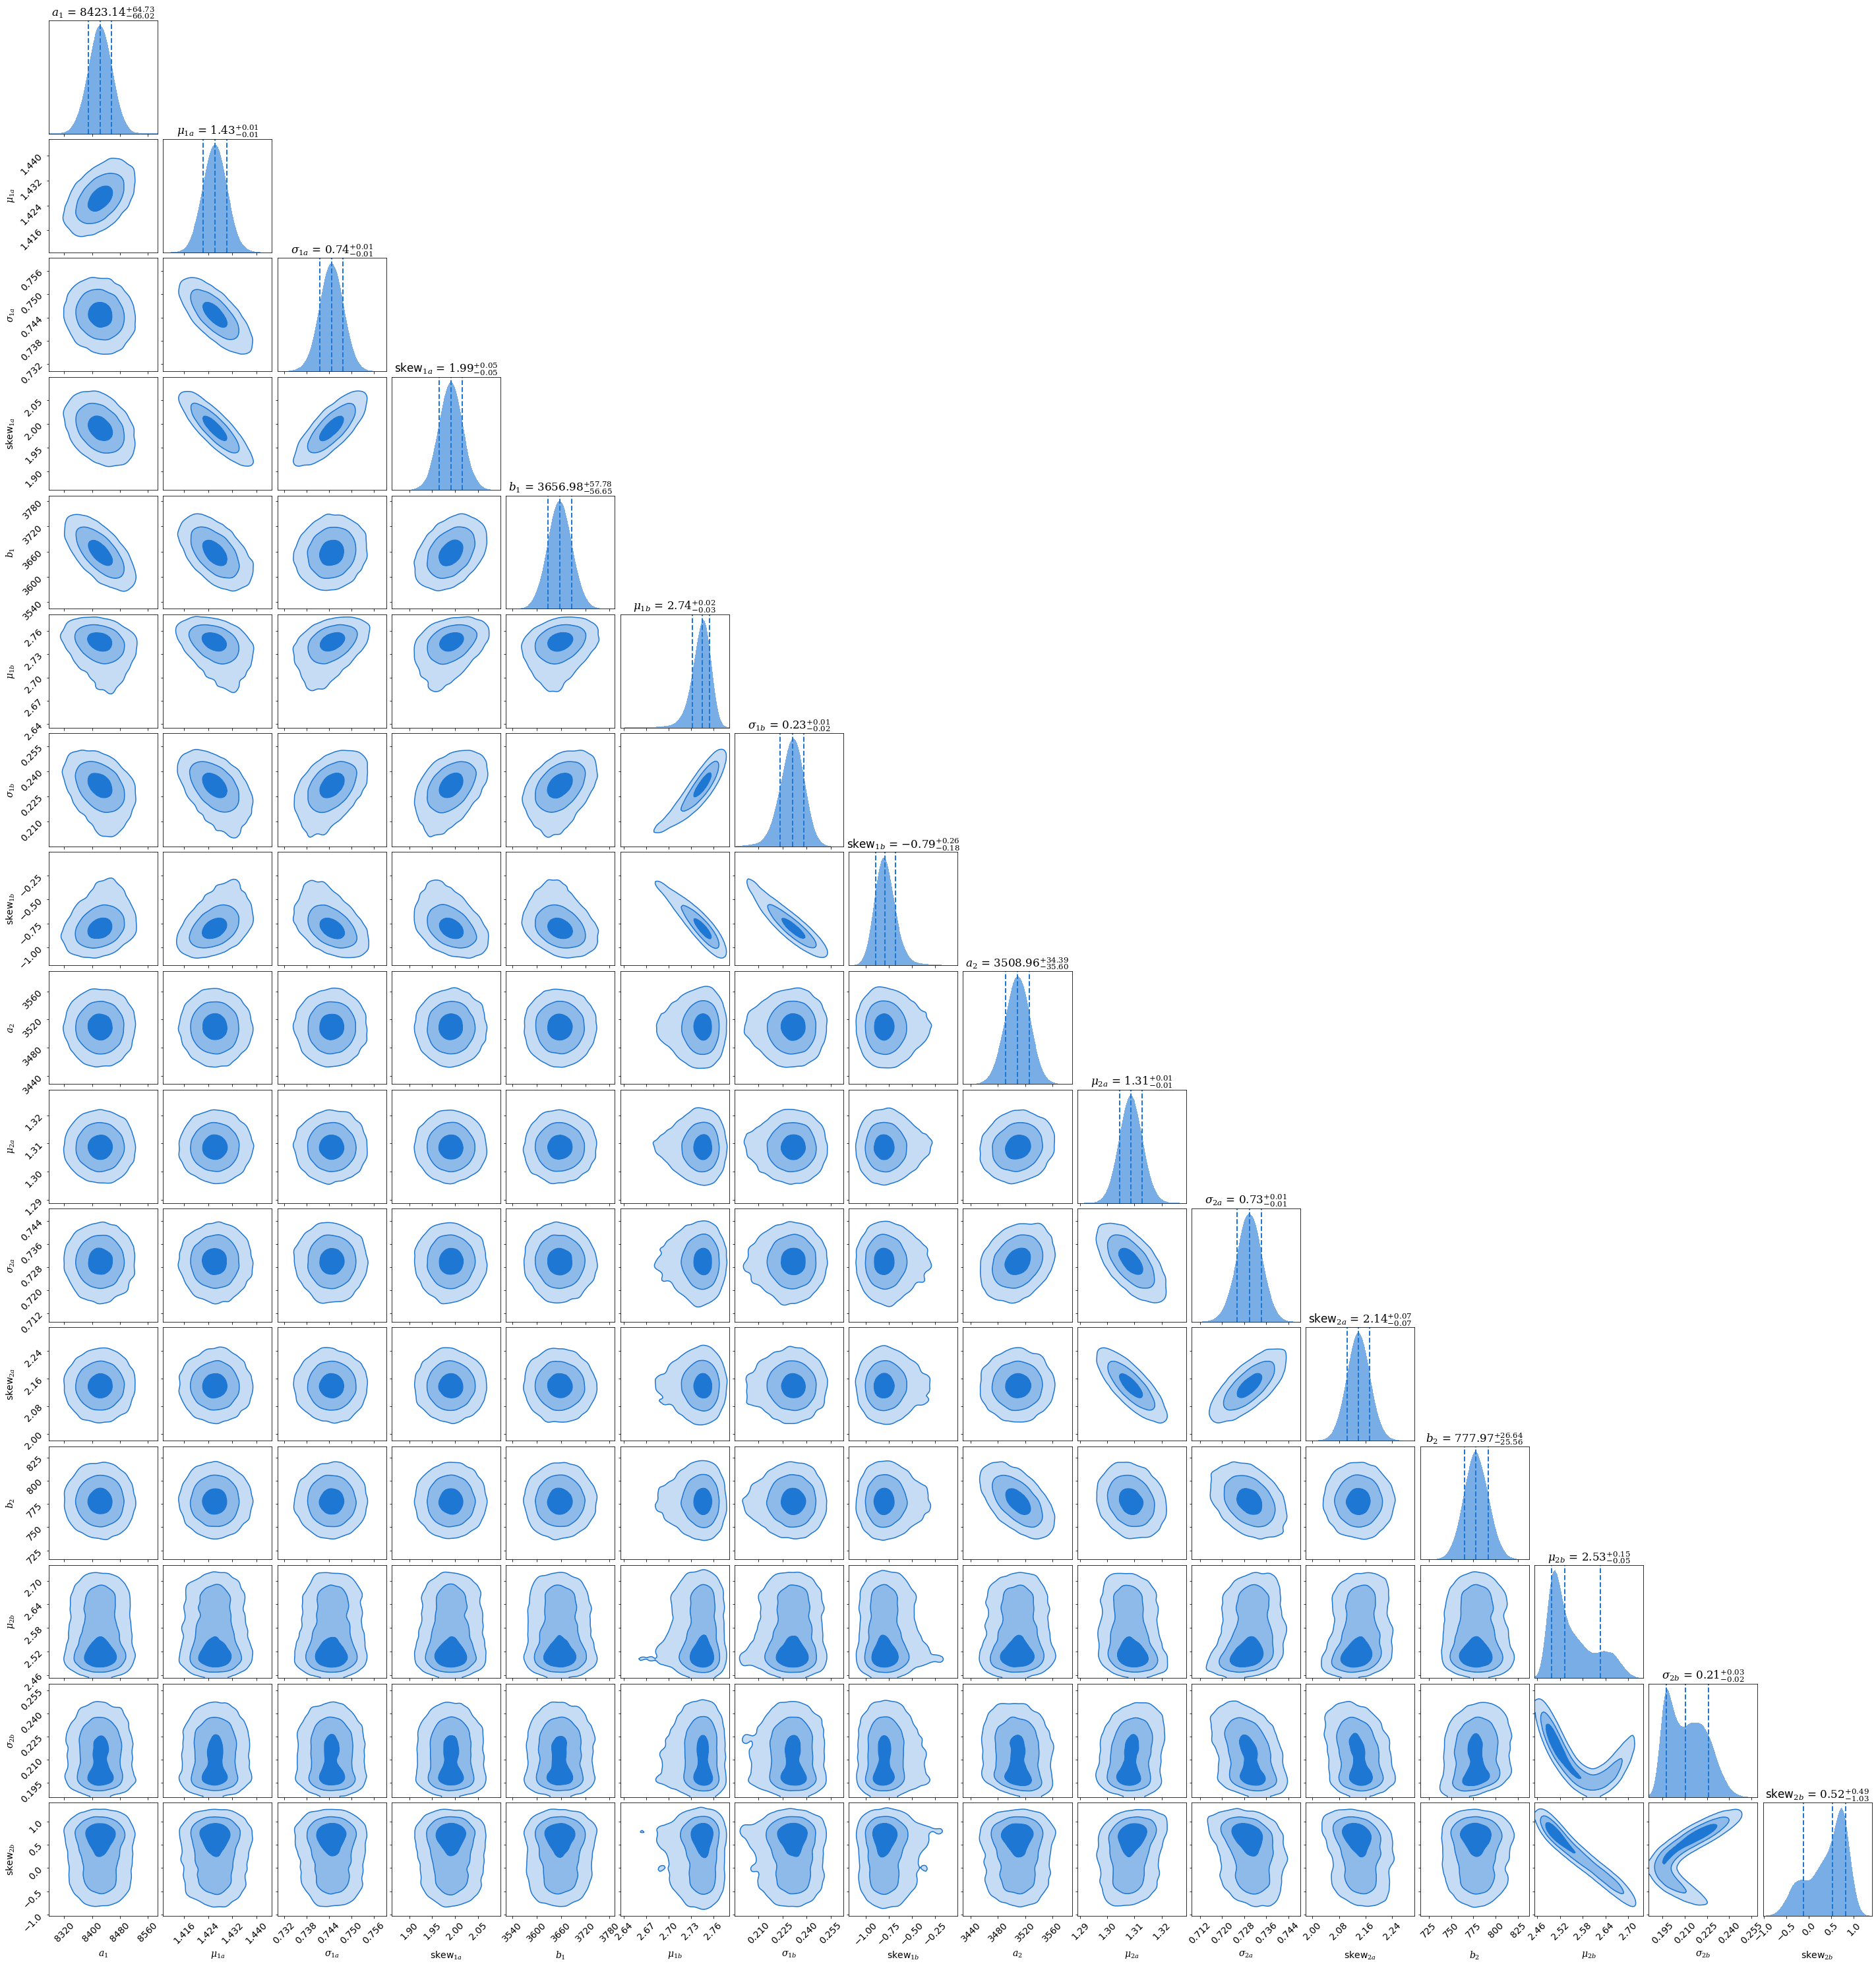

In [51]:
n_params = len(labels2_bi)

fig, axes = dyplot.cornerplot(dres2_VF_ur, smooth=0.03, 
                              labels=labels2_bi, 
                              truths=VF_ur_bestfit2.x,
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(n_params, n_params, figsize=(2.5*n_params, 2.6*n_params)), 
                              color='#1f77d4')

In [52]:
lnzM2_VF_ur = dres2_VF_ur.logz[-1]
lnzM2_VF_ur

-1240.4597709626619

In [53]:
VF_ur_bestfit2_dynesty,_ = dyfunc.mean_and_cov(dres2_VF_ur.samples, 
                                               np.exp(dres2_VF_ur.logwt - lnzM2_VF_ur))

VF_ur_bestfit2_dynesty

array([ 8.42304840e+03,  1.42625480e+00,  7.44721673e-01,  1.99088888e+00,
        3.65725346e+03,  2.74335004e+00,  2.30875725e-01, -7.84145199e-01,
        3.50882866e+03,  1.30871050e+00,  7.29916878e-01,  2.13933530e+00,
        7.78138019e+02,  2.55216711e+00,  2.11541579e-01,  4.10173946e-01])

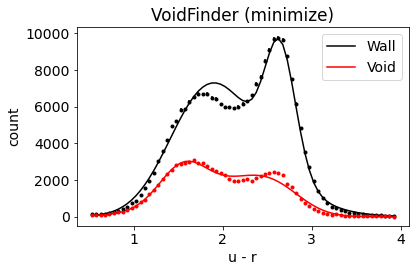

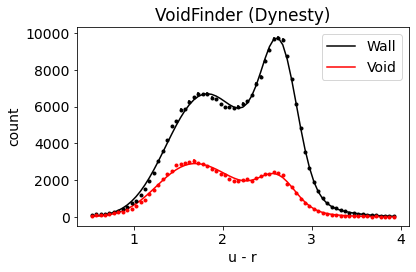

In [54]:
Model_2_plot(VF_ur_bestfit2.x, 
             ur_NSA[wall_vf], 
             ur_NSA[void_vf], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='VoidFinder (minimize)')

Model_2_plot(VF_ur_bestfit2_dynesty, 
             ur_NSA[wall_vf], 
             ur_NSA[void_vf], 
             ur_bins, 
             2, 
             xlabel_text='u - r', 
             title_text='VoidFinder (Dynesty)')

## Bayes Factor

In [55]:
lnB12_V2_ur = lnzM1_V2_ur - lnzM2_V2_ur

B12_V2_ur = np.exp(lnB12_V2_ur)

print('V2 (u - r): B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_V2_ur, np.log10(B12_V2_ur)))

V2 (u - r): B12 = 1.6e-29; log(B12) = -28.8


In [56]:
lnB12_VF_ur = lnzM1_VF_ur - lnzM2_VF_ur

B12_VF_ur = np.exp(lnB12_VF_ur)

print('VoidFinder (u - r): B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_VF_ur, lnB12_VF_ur*np.log10(np.exp(1))))

VoidFinder (u - r): B12 = 0; log(B12) = -1555.761


So both VoidFinder and V$^2$ favor $\mathcal{M}_2$, in which the two data sets come from different parent distributions, although VoidFinder favors it much more than V$^2$.